The objective of this mini-project is to define and train a Conditional VAE
(CVAE), by following the instructions below:

## Find resources that explain what a CVAE is, it’s difference with VAEs, the loss functions used to train it etc.


https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95

https://medium.com/@sofeikov/implementing-conditional-variational-auto-encoders-cvae-from-scratch-29fcbb8cb08f

https://theaiacademy.blogspot.com/2020/05/understanding-conditional-variational.html

**À expliquer** 

Problème du VAE : 1) impossibilité de générer un nouvel échantillon (image+label) en imposant des conditions spécifiques (par exemple, générer une image à partir du label)
Ce qu'il faudrait expliquer : prior distribution, ce qu'est un encodeur/décodeur, AE et VAE

Différence avec VAE : Pour générer une nouvelle observation x, la VAE, on sélectionne un z à partir de la distribution a priori et on retrouve le label de x en calculant P(x sachant z). Avec la CVAE, on selectionne un (z sachant y) ie on choisit le label du x qu'on veut générer, et ensuite, on génére (x sachant y et z)

Choix de la loss function (voir cours VAE slide 35)

https://cedric.cnam.fr/vertigo/cours/RCP211/auto-encodeurs-variationnels.html



**Fin**



## Train a CVAE on the Fashion-MNIST dataset (available to download from torchvision).

Explain and argue the different choices you make along the way, in particular:
– The choice of the architecture, the layer types, the layer sizes and the
activations.
– The choice of the different hyper-parameters: batch size, learning rate,
number of epochs, regularization weight...
– The choice of the loss function, the different terms in it, and their
individual purposes.


Include links to articles, blog posts, videos... that helped you decide on the above choices.


Include the code of the different trials/experiments that helped you decide on the above choices.




In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [75]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

fashion_mnist_labels = [
    "T-shirt/top",
    "Pants",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


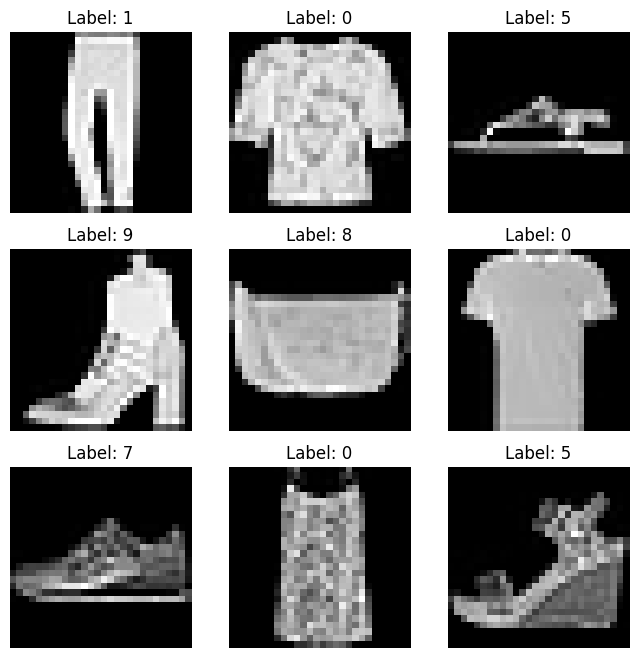

[0 1 2 3 4 5 6 7 8 9]
10


In [5]:
# Plot 9 random images from the MNIST train dataset
def plot_images(img_dataset):
    """Plots 9 random images from the given dataset

    Args:
        img_dataset (torch.utils.data.Dataset): The dataset to plot images from
    """

    # Set up a 3x3 grid for plotting 9 random images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
    # Plot 9 random images from the img_dataset
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  # Pick a random index
        img, label = img_dataset[random_idx]  # Get the image and its label
        figure.add_subplot(rows, cols, i)  # Add subplot
        plt.title(f'Label: {label}')  # Set title to show the label
        plt.axis("off")  # Turn off axis
        plt.imshow(img.squeeze(), cmap="gray")  # Plot image
    
    plt.show()  # Display the figure

plot_images(train_dataset)
print(np.unique(train_dataset.targets[:]))
num_classes = np.size(np.unique(train_dataset.targets[:]))
print(num_classes)

In [42]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4) + kernel_size = 3 : capturer des détails plus fins
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4+ num_classes, latent_dim)  #pour forcer à avor des valeurs positives, on prend le log de var et non pas var
        self.fc_decode = nn.Linear(latent_dim+ num_classes, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    #TO DO (concatenation de x et y)
    def encode(self, x, y):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        x = torch.cat((x,y), dim = 1) # Concatenate and flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
     #TO DO (concatenation de z et y)
    def decode(self, z, y):
        z = torch.cat((z,y), dim = 1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x
        
    #TO DO (ajout de y en argument)
    def forward(self, x, y):
        mu, logvar = self.encode(x,y)
        z = self.sample(mu, logvar)
        return self.decode(z,y), mu, logvar

$$
\text{Sortie} = \left\lfloor \frac{\text{Entrée} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

#### Loss function

In [43]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') #terme de reconstruction (noir et blanc contraste sinon mse)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #envoyer sur une loi normale
    return BCE + beta * KLD

In [44]:
# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1

# Initialize the VAE model and the Adam optimizer
cvae = CVAE(latent_dim=latent_dim)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #running_test_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 270.5809
Epoch 2, Training loss: 257.4013
Epoch 3, Training loss: 255.8330
Epoch 4, Training loss: 254.9700
Epoch 5, Training loss: 254.2281
Epoch 6, Training loss: 253.7852
Epoch 7, Training loss: 253.3877
Epoch 8, Training loss: 253.1193
Epoch 9, Training loss: 252.9134
Epoch 10, Training loss: 252.5462
Epoch 11, Training loss: 252.3131
Epoch 12, Training loss: 252.1821
Epoch 13, Training loss: 251.9525
Epoch 14, Training loss: 251.8490
Epoch 15, Training loss: 251.5638
Epoch 16, Training loss: 251.4523
Epoch 17, Training loss: 251.3476
Epoch 18, Training loss: 251.2058
Epoch 19, Training loss: 251.0375
Epoch 20, Training loss: 250.9012
Epoch 21, Training loss: 250.7898
Epoch 22, Training loss: 250.6626
Epoch 23, Training loss: 250.6041
Epoch 24, Training loss: 250.4958
Epoch 25, Training loss: 250.3843
Epoch 26, Training loss: 250.2729
Epoch 27, Training loss: 250.2000
Epoch 28, Training loss: 250.1609
Epoch 29, Training loss: 250.0239
Epoch 30, Training loss

### Visualize results

Original labels shape: torch.Size([128])
One-hot labels shape: torch.Size([128, 10])


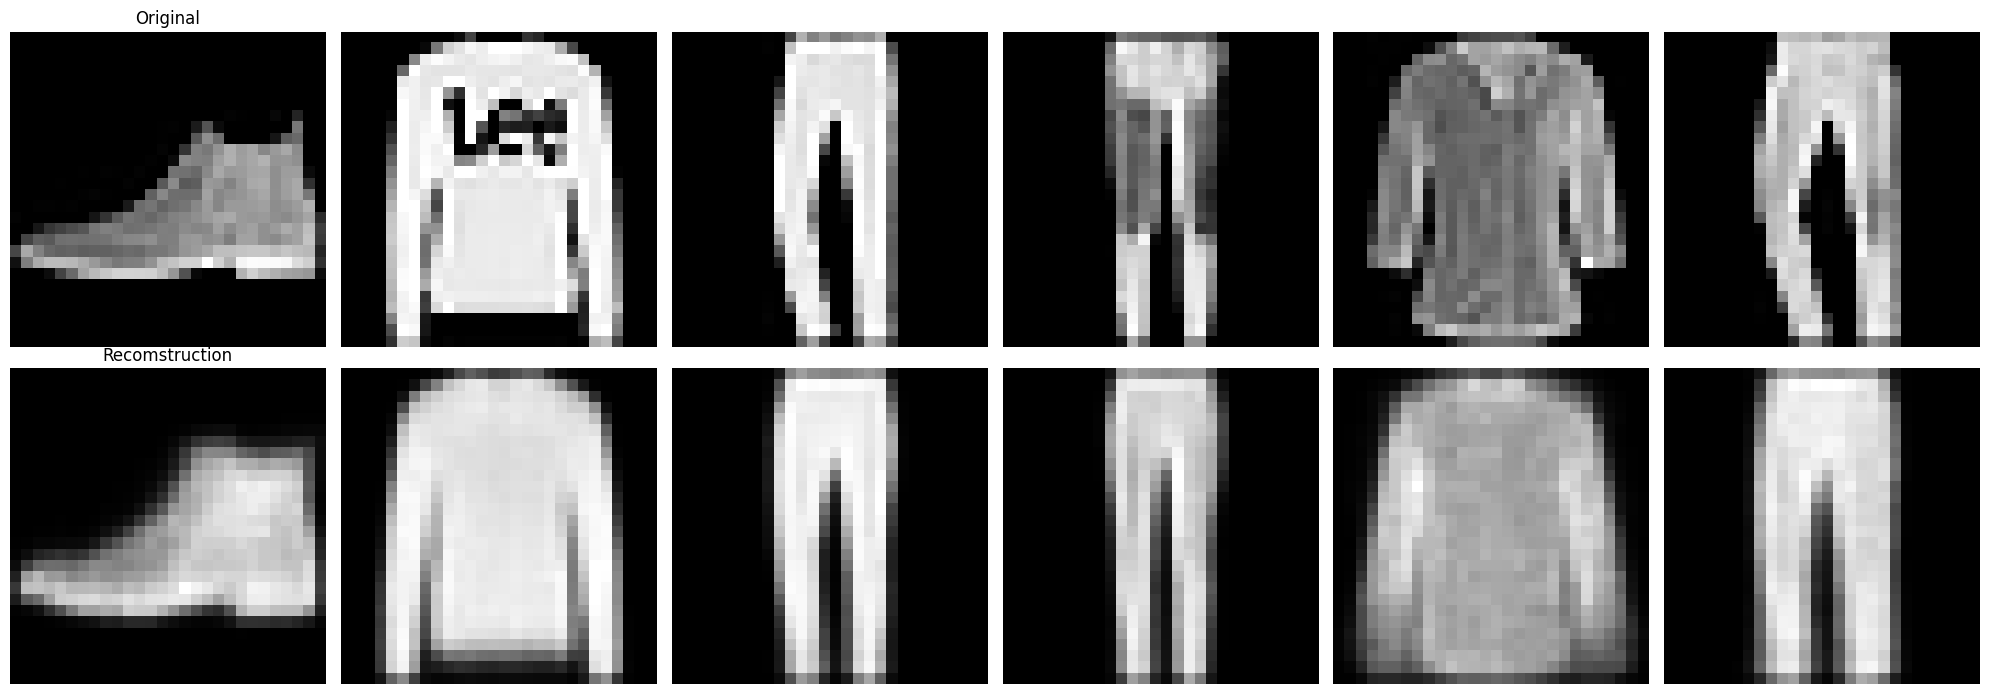

Ankle boot
Pullover
Pants
Pants
Shirt
Pants


In [81]:
# TODO: Define or import the image_comparison function
from utils import image_comparison 
# Select a batch of images from the test dataset
random_images = next(iter(test_loader))
# Vérifier la forme des étiquettes
labels = random_images[1]
print(f"Original labels shape: {labels.shape}")  # Devrait être (batch_size,)

# Convertir les étiquettes en one-hot si ce n'est pas déjà fait
if len(labels.shape) == 1:  # Vérifie si c'est un vecteur
    labels_one_hot = F.one_hot(labels, num_classes=10)  # Convertir en one-hot
else:
    labels_one_hot = labels  # Si déjà en one-hot

print(f"One-hot labels shape: {labels_one_hot.shape}")  # Devrait être (batch_size, 10)

# Passer les données au modèle
recons, _, _ = cvae(random_images[0].to(device), labels_one_hot.to(device))

# Reshape the images for plotting
random_images = random_images[0].cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

    
labels = labels[:6]
for i in labels:
    print(fashion_mnist_labels[i])
labels_one_hot = labels_one_hot[:10,:]

loss ok en vrai car les images sont plutôt bien reconstruites (5/6 sont largement distinguables)

## Generate 5 new samples for each class of the Fashion-MNIST dataset using the CVAE.


Ankle boot
Pullover
Pants
Pants
Shirt


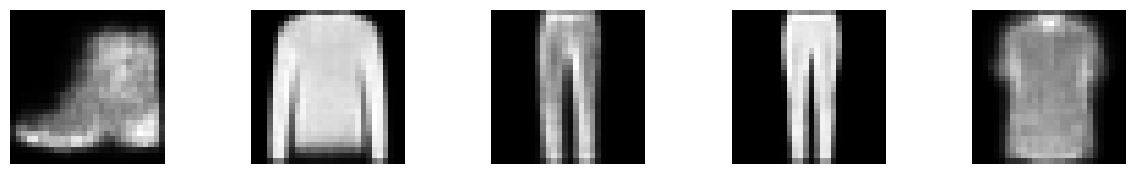

In [79]:
def generate_sample(num_samples=5):
    #selection de labels
    random_images = next(iter(test_loader))
    labels = random_images[1]
    labels_one_hot = F.one_hot(labels, num_classes=10)  # Convertir en one-hot

    labels = labels[:num_samples]
    labels_one_hot = labels_one_hot[:num_samples,:]
        
    cvae.eval()
    with torch.no_grad():
        # TODO: Sample random latent vectors
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample random latent vectors
        y = labels_one_hot.to(device)

        for i in labels:
            print(fashion_mnist_labels[i])
         
        samples = cvae.decode(z,y) # Decode the latent vectors
        samples = samples.cpu().view(num_samples, 1, 28, 28) # Reshape the samples

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

generate_sample()

## Plot different visualizations for the results: the curves of the different terms in the loss functions, the learnt latent space...